# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

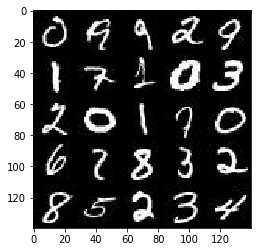

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

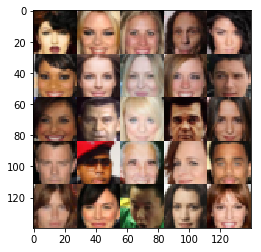

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name='real_input')
    input_z = tf.placeholder(tf.float32, [None, z_dim], name='generator_input')
    
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    
    return input_real, input_z, learning_rate

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        leaky_relu_alpha = 0.2

        conv1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        conv1_relu = tf.maximum(conv1, conv1 * leaky_relu_alpha)
        
        conv2 = tf.layers.conv2d(conv1_relu, 128, 5, strides=2, padding='same')
        conv2_batch_normal = tf.layers.batch_normalization(conv2, training=True)
        conv2_relu = tf.maximum(conv2_batch_normal, conv2_batch_normal * leaky_relu_alpha)
        
        conv3 = tf.layers.conv2d(conv2_relu, 256, 5, strides=2, padding='same')
        conv3_batch_normal = tf.layers.batch_normalization(conv3, training=True)
        conv3_relu = tf.maximum(conv3_batch_normal, conv3_batch_normal * leaky_relu_alpha)
        
        conv3_flat = tf.reshape(conv3_relu, (-1, 4*4*256))
        
        logits = tf.layers.dense(conv3_flat, 1)
        output = tf.sigmoid(logits)

    return output, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not is_train):
        leaky_relu_alpha = 0.2
        
        fc = tf.layers.dense(z, 7*7*512)
        
        fc = tf.reshape(fc, (-1, 7, 7, 512))
        fc_batch_normal = tf.layers.batch_normalization(fc, training=is_train)
        fc_relu = tf.maximum(fc_batch_normal, fc_batch_normal * leaky_relu_alpha)
        
        deconv1 = tf.layers.conv2d_transpose(fc_relu, 128, 5, strides=1, padding='same')
        deconv1_batch_normal = tf.layers.batch_normalization(deconv1, training=is_train)
        deconv1_relu = tf.maximum(deconv1_batch_normal, deconv1_batch_normal * leaky_relu_alpha)
        
        deconv2 = tf.layers.conv2d_transpose(deconv1_relu, 64, 5, strides=2, padding='same')
        deconv2_batch_normal = tf.layers.batch_normalization(deconv2, training=is_train)
        deconv2_relu = tf.maximum(deconv2_batch_normal, deconv2_batch_normal * leaky_relu_alpha)

        logits = tf.layers.conv2d_transpose(deconv2_relu, out_channel_dim, 5, strides=2, padding='same')
        
        output = tf.tanh(logits)
    return output

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    gen_out = generator(input_z, out_channel_dim)
    
    disc_out_real, disc_logit_real = discriminator(input_real)
    disc_out_fake, disc_logit_fake = discriminator(gen_out, reuse=True)
    
    disc_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=disc_logit_real,
                                                                            labels = tf.ones_like(disc_out_real) * 0.9))
    
    disc_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=disc_logit_fake,
                                                                            labels = tf.zeros_like(disc_out_fake)))
    
    disc_loss = disc_loss_real + disc_loss_fake
    
    gen_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=disc_logit_fake,
                                                                      labels=tf.ones_like(disc_out_fake)))
    
    return disc_loss, gen_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    train_vars = tf.trainable_variables()
    
    gen_vars = [var for var in train_vars if var.name.startswith('generator')]
    disc_vars = [var for var in train_vars if var.name.startswith('discriminator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        gen_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=gen_vars)
        disc_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=disc_vars)
    
    return disc_opt, gen_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """  
    image_width = data_shape[1]
    image_height = data_shape[2]
    image_channels = data_shape[3]
    
    input_real, input_z, _ = model_inputs(image_width, image_height, image_channels, z_dim)    
    
    disc_loss, gen_loss = model_loss(input_real, input_z, image_channels)    
    disc_opt, gen_opt = model_opt(disc_loss, gen_loss, learning_rate, beta1)
    
    steps = 0
    
    print_output_interval = 20
    show_output_interval = 100
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps = steps + 1
                
                batch_images = batch_images * 2.0
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(disc_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(gen_opt, feed_dict={input_z: batch_z, input_real: batch_images})
                
                if steps % print_output_interval == 0:
                    gen_train_loss = gen_loss.eval({input_z: batch_z})
                    disc_train_loss = disc_loss.eval({input_real: batch_images, input_z: batch_z})
                    
                    print("Epoch => {}/{} ".format(epoch_i + 1, epoch_count),
                          "Discriminator Loss: {:.3f}".format(disc_train_loss),
                          "Generator Loss: {:.3f}".format(gen_train_loss))
                
                if steps % show_output_interval == 0:
                    print ("\nPlot Number > {}".format(steps // show_output_interval))
                    show_generator_output(sess, 25, input_z, image_channels, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch => 1/2  Discriminator Loss: 0.604 Generator Loss: 2.035
Epoch => 1/2  Discriminator Loss: 1.220 Generator Loss: 1.123
Epoch => 1/2  Discriminator Loss: 1.330 Generator Loss: 1.156
Epoch => 1/2  Discriminator Loss: 1.215 Generator Loss: 0.833
Epoch => 1/2  Discriminator Loss: 2.313 Generator Loss: 3.929

Plot Number > 1


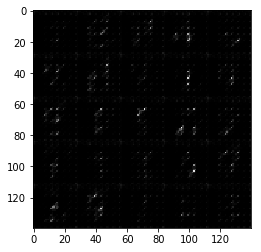

Epoch => 1/2  Discriminator Loss: 1.050 Generator Loss: 0.922
Epoch => 1/2  Discriminator Loss: 1.122 Generator Loss: 0.833
Epoch => 1/2  Discriminator Loss: 1.481 Generator Loss: 0.583
Epoch => 1/2  Discriminator Loss: 1.217 Generator Loss: 2.150
Epoch => 1/2  Discriminator Loss: 1.379 Generator Loss: 1.494

Plot Number > 2


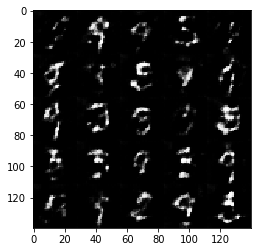

Epoch => 1/2  Discriminator Loss: 1.053 Generator Loss: 1.012
Epoch => 1/2  Discriminator Loss: 1.155 Generator Loss: 0.878
Epoch => 1/2  Discriminator Loss: 1.236 Generator Loss: 0.682
Epoch => 1/2  Discriminator Loss: 1.147 Generator Loss: 0.809
Epoch => 1/2  Discriminator Loss: 1.178 Generator Loss: 0.799

Plot Number > 3


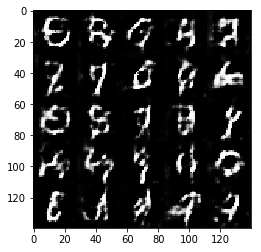

Epoch => 1/2  Discriminator Loss: 1.167 Generator Loss: 1.362
Epoch => 1/2  Discriminator Loss: 1.590 Generator Loss: 0.423
Epoch => 1/2  Discriminator Loss: 1.239 Generator Loss: 0.738
Epoch => 1/2  Discriminator Loss: 1.132 Generator Loss: 1.160
Epoch => 1/2  Discriminator Loss: 1.034 Generator Loss: 0.932

Plot Number > 4


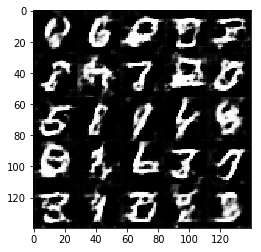

Epoch => 1/2  Discriminator Loss: 1.130 Generator Loss: 1.388
Epoch => 1/2  Discriminator Loss: 1.166 Generator Loss: 1.423
Epoch => 1/2  Discriminator Loss: 1.241 Generator Loss: 1.222
Epoch => 1/2  Discriminator Loss: 1.647 Generator Loss: 2.446
Epoch => 1/2  Discriminator Loss: 1.052 Generator Loss: 1.149

Plot Number > 5


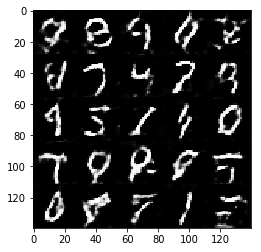

Epoch => 1/2  Discriminator Loss: 0.972 Generator Loss: 1.184
Epoch => 1/2  Discriminator Loss: 1.524 Generator Loss: 0.465
Epoch => 1/2  Discriminator Loss: 1.029 Generator Loss: 1.125
Epoch => 1/2  Discriminator Loss: 1.217 Generator Loss: 0.743
Epoch => 1/2  Discriminator Loss: 1.128 Generator Loss: 0.835

Plot Number > 6


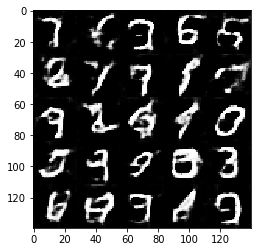

Epoch => 1/2  Discriminator Loss: 1.190 Generator Loss: 0.748
Epoch => 1/2  Discriminator Loss: 1.117 Generator Loss: 1.098
Epoch => 1/2  Discriminator Loss: 1.013 Generator Loss: 1.188
Epoch => 1/2  Discriminator Loss: 1.183 Generator Loss: 0.960
Epoch => 1/2  Discriminator Loss: 1.003 Generator Loss: 1.415

Plot Number > 7


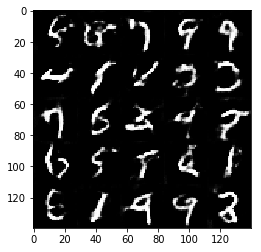

Epoch => 1/2  Discriminator Loss: 1.170 Generator Loss: 0.767
Epoch => 1/2  Discriminator Loss: 1.094 Generator Loss: 0.887
Epoch => 1/2  Discriminator Loss: 1.158 Generator Loss: 0.763
Epoch => 1/2  Discriminator Loss: 1.110 Generator Loss: 0.786
Epoch => 1/2  Discriminator Loss: 1.186 Generator Loss: 0.737

Plot Number > 8


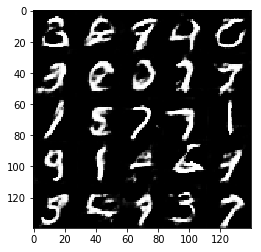

Epoch => 1/2  Discriminator Loss: 1.746 Generator Loss: 2.764
Epoch => 1/2  Discriminator Loss: 1.047 Generator Loss: 0.972
Epoch => 1/2  Discriminator Loss: 1.114 Generator Loss: 1.102
Epoch => 1/2  Discriminator Loss: 0.975 Generator Loss: 1.320
Epoch => 1/2  Discriminator Loss: 0.884 Generator Loss: 1.591

Plot Number > 9


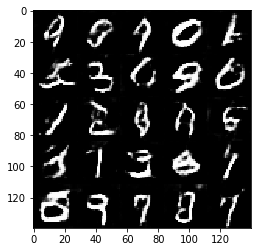

Epoch => 1/2  Discriminator Loss: 1.054 Generator Loss: 0.952
Epoch => 2/2  Discriminator Loss: 1.258 Generator Loss: 0.682
Epoch => 2/2  Discriminator Loss: 1.475 Generator Loss: 2.088
Epoch => 2/2  Discriminator Loss: 1.062 Generator Loss: 1.914
Epoch => 2/2  Discriminator Loss: 1.975 Generator Loss: 3.560

Plot Number > 10


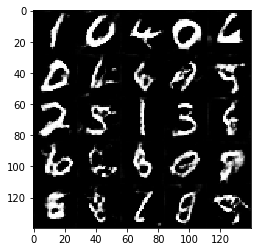

Epoch => 2/2  Discriminator Loss: 1.213 Generator Loss: 0.722
Epoch => 2/2  Discriminator Loss: 1.949 Generator Loss: 3.028
Epoch => 2/2  Discriminator Loss: 1.114 Generator Loss: 1.428
Epoch => 2/2  Discriminator Loss: 0.809 Generator Loss: 1.926
Epoch => 2/2  Discriminator Loss: 1.040 Generator Loss: 0.816

Plot Number > 11


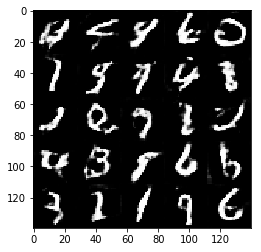

Epoch => 2/2  Discriminator Loss: 1.064 Generator Loss: 0.834
Epoch => 2/2  Discriminator Loss: 1.080 Generator Loss: 1.341
Epoch => 2/2  Discriminator Loss: 0.900 Generator Loss: 0.999
Epoch => 2/2  Discriminator Loss: 1.567 Generator Loss: 0.513
Epoch => 2/2  Discriminator Loss: 0.976 Generator Loss: 1.094

Plot Number > 12


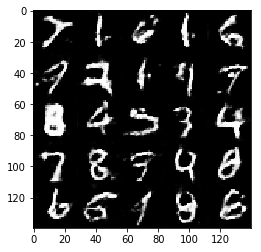

Epoch => 2/2  Discriminator Loss: 0.995 Generator Loss: 0.866
Epoch => 2/2  Discriminator Loss: 1.168 Generator Loss: 0.765
Epoch => 2/2  Discriminator Loss: 1.142 Generator Loss: 0.757
Epoch => 2/2  Discriminator Loss: 1.544 Generator Loss: 0.479
Epoch => 2/2  Discriminator Loss: 0.748 Generator Loss: 1.406

Plot Number > 13


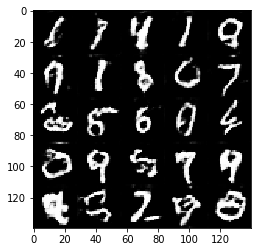

Epoch => 2/2  Discriminator Loss: 0.904 Generator Loss: 1.123
Epoch => 2/2  Discriminator Loss: 2.901 Generator Loss: 4.766
Epoch => 2/2  Discriminator Loss: 0.998 Generator Loss: 0.945
Epoch => 2/2  Discriminator Loss: 1.241 Generator Loss: 0.685
Epoch => 2/2  Discriminator Loss: 0.800 Generator Loss: 1.534

Plot Number > 14


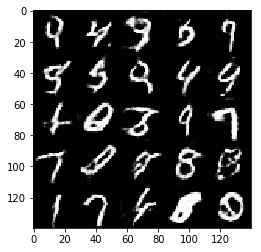

Epoch => 2/2  Discriminator Loss: 0.849 Generator Loss: 1.132
Epoch => 2/2  Discriminator Loss: 0.862 Generator Loss: 2.140
Epoch => 2/2  Discriminator Loss: 1.795 Generator Loss: 0.455
Epoch => 2/2  Discriminator Loss: 0.672 Generator Loss: 1.769
Epoch => 2/2  Discriminator Loss: 0.915 Generator Loss: 1.306

Plot Number > 15


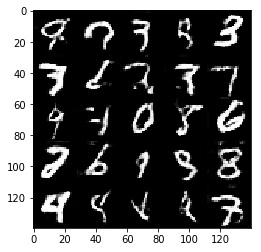

Epoch => 2/2  Discriminator Loss: 1.958 Generator Loss: 0.325
Epoch => 2/2  Discriminator Loss: 0.883 Generator Loss: 1.068
Epoch => 2/2  Discriminator Loss: 1.158 Generator Loss: 0.763
Epoch => 2/2  Discriminator Loss: 1.013 Generator Loss: 1.005
Epoch => 2/2  Discriminator Loss: 0.816 Generator Loss: 1.695

Plot Number > 16


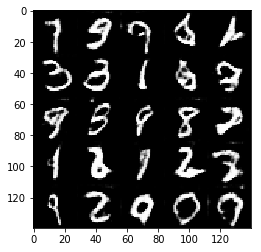

Epoch => 2/2  Discriminator Loss: 0.735 Generator Loss: 1.395
Epoch => 2/2  Discriminator Loss: 0.865 Generator Loss: 3.388
Epoch => 2/2  Discriminator Loss: 1.380 Generator Loss: 0.603
Epoch => 2/2  Discriminator Loss: 1.763 Generator Loss: 3.666
Epoch => 2/2  Discriminator Loss: 0.812 Generator Loss: 1.189

Plot Number > 17


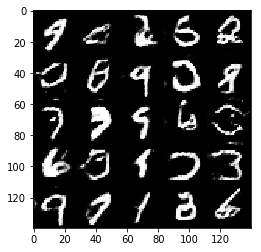

Epoch => 2/2  Discriminator Loss: 0.947 Generator Loss: 0.926
Epoch => 2/2  Discriminator Loss: 1.131 Generator Loss: 2.820
Epoch => 2/2  Discriminator Loss: 0.807 Generator Loss: 1.708
Epoch => 2/2  Discriminator Loss: 1.259 Generator Loss: 0.663
Epoch => 2/2  Discriminator Loss: 0.928 Generator Loss: 1.597

Plot Number > 18


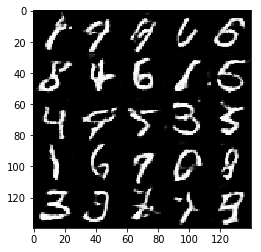

Epoch => 2/2  Discriminator Loss: 1.886 Generator Loss: 0.396
Epoch => 2/2  Discriminator Loss: 1.141 Generator Loss: 3.425
Epoch => 2/2  Discriminator Loss: 0.757 Generator Loss: 1.756


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch => 1/1  Discriminator Loss: 0.711 Generator Loss: 2.684
Epoch => 1/1  Discriminator Loss: 1.095 Generator Loss: 1.494
Epoch => 1/1  Discriminator Loss: 1.385 Generator Loss: 2.920
Epoch => 1/1  Discriminator Loss: 1.139 Generator Loss: 0.833
Epoch => 1/1  Discriminator Loss: 0.987 Generator Loss: 1.183

Plot Number > 1


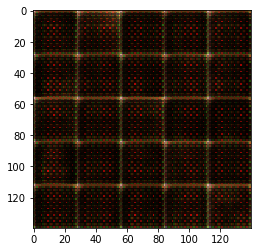

Epoch => 1/1  Discriminator Loss: 1.071 Generator Loss: 1.444
Epoch => 1/1  Discriminator Loss: 1.777 Generator Loss: 0.492
Epoch => 1/1  Discriminator Loss: 1.780 Generator Loss: 0.421
Epoch => 1/1  Discriminator Loss: 1.566 Generator Loss: 2.605
Epoch => 1/1  Discriminator Loss: 1.659 Generator Loss: 0.480

Plot Number > 2


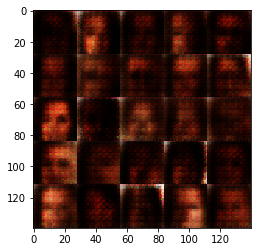

Epoch => 1/1  Discriminator Loss: 1.394 Generator Loss: 1.503
Epoch => 1/1  Discriminator Loss: 0.901 Generator Loss: 1.212
Epoch => 1/1  Discriminator Loss: 1.138 Generator Loss: 1.699
Epoch => 1/1  Discriminator Loss: 1.287 Generator Loss: 1.981
Epoch => 1/1  Discriminator Loss: 0.997 Generator Loss: 1.203

Plot Number > 3


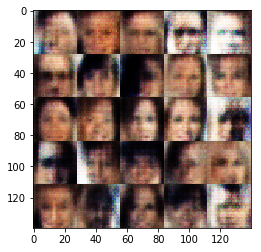

Epoch => 1/1  Discriminator Loss: 1.306 Generator Loss: 0.998
Epoch => 1/1  Discriminator Loss: 1.186 Generator Loss: 0.915
Epoch => 1/1  Discriminator Loss: 1.349 Generator Loss: 0.747
Epoch => 1/1  Discriminator Loss: 1.341 Generator Loss: 0.828
Epoch => 1/1  Discriminator Loss: 1.641 Generator Loss: 0.676

Plot Number > 4


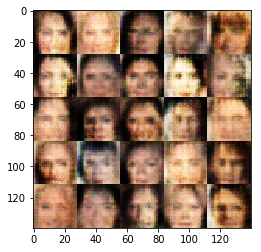

Epoch => 1/1  Discriminator Loss: 1.245 Generator Loss: 1.066
Epoch => 1/1  Discriminator Loss: 1.279 Generator Loss: 0.888
Epoch => 1/1  Discriminator Loss: 1.468 Generator Loss: 0.511
Epoch => 1/1  Discriminator Loss: 1.607 Generator Loss: 0.408
Epoch => 1/1  Discriminator Loss: 1.366 Generator Loss: 0.687

Plot Number > 5


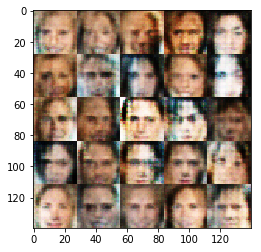

Epoch => 1/1  Discriminator Loss: 1.190 Generator Loss: 1.311
Epoch => 1/1  Discriminator Loss: 1.231 Generator Loss: 1.162
Epoch => 1/1  Discriminator Loss: 1.453 Generator Loss: 0.798
Epoch => 1/1  Discriminator Loss: 1.150 Generator Loss: 0.765
Epoch => 1/1  Discriminator Loss: 1.402 Generator Loss: 0.843

Plot Number > 6


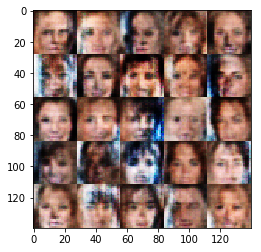

Epoch => 1/1  Discriminator Loss: 1.306 Generator Loss: 1.032
Epoch => 1/1  Discriminator Loss: 1.664 Generator Loss: 1.712
Epoch => 1/1  Discriminator Loss: 1.173 Generator Loss: 0.967
Epoch => 1/1  Discriminator Loss: 1.139 Generator Loss: 1.216
Epoch => 1/1  Discriminator Loss: 1.280 Generator Loss: 1.163

Plot Number > 7


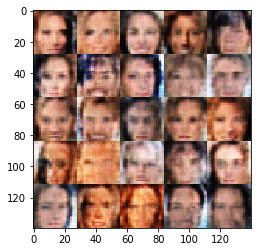

Epoch => 1/1  Discriminator Loss: 1.180 Generator Loss: 1.184
Epoch => 1/1  Discriminator Loss: 1.092 Generator Loss: 1.120
Epoch => 1/1  Discriminator Loss: 1.216 Generator Loss: 1.053
Epoch => 1/1  Discriminator Loss: 1.192 Generator Loss: 0.833
Epoch => 1/1  Discriminator Loss: 1.350 Generator Loss: 0.881

Plot Number > 8


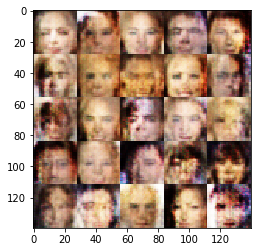

Epoch => 1/1  Discriminator Loss: 1.188 Generator Loss: 0.868
Epoch => 1/1  Discriminator Loss: 1.388 Generator Loss: 0.627
Epoch => 1/1  Discriminator Loss: 1.329 Generator Loss: 1.538
Epoch => 1/1  Discriminator Loss: 1.257 Generator Loss: 0.737
Epoch => 1/1  Discriminator Loss: 1.161 Generator Loss: 0.832

Plot Number > 9


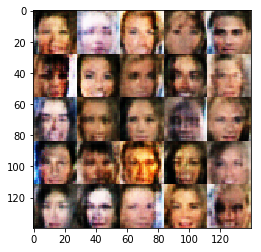

Epoch => 1/1  Discriminator Loss: 1.220 Generator Loss: 0.773
Epoch => 1/1  Discriminator Loss: 1.184 Generator Loss: 0.978
Epoch => 1/1  Discriminator Loss: 1.258 Generator Loss: 0.975
Epoch => 1/1  Discriminator Loss: 1.312 Generator Loss: 0.688
Epoch => 1/1  Discriminator Loss: 1.250 Generator Loss: 1.352

Plot Number > 10


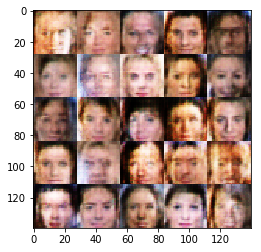

Epoch => 1/1  Discriminator Loss: 1.118 Generator Loss: 0.905
Epoch => 1/1  Discriminator Loss: 1.362 Generator Loss: 2.094
Epoch => 1/1  Discriminator Loss: 1.114 Generator Loss: 0.975
Epoch => 1/1  Discriminator Loss: 1.306 Generator Loss: 1.124
Epoch => 1/1  Discriminator Loss: 1.366 Generator Loss: 0.738

Plot Number > 11


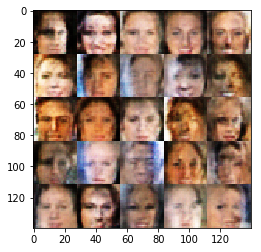

Epoch => 1/1  Discriminator Loss: 1.168 Generator Loss: 0.778
Epoch => 1/1  Discriminator Loss: 1.295 Generator Loss: 1.070
Epoch => 1/1  Discriminator Loss: 1.181 Generator Loss: 0.879
Epoch => 1/1  Discriminator Loss: 1.368 Generator Loss: 0.560
Epoch => 1/1  Discriminator Loss: 1.262 Generator Loss: 0.656

Plot Number > 12


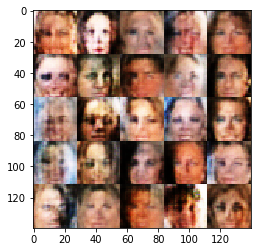

Epoch => 1/1  Discriminator Loss: 1.187 Generator Loss: 1.394
Epoch => 1/1  Discriminator Loss: 1.330 Generator Loss: 1.261
Epoch => 1/1  Discriminator Loss: 1.316 Generator Loss: 0.769
Epoch => 1/1  Discriminator Loss: 1.462 Generator Loss: 1.143
Epoch => 1/1  Discriminator Loss: 1.197 Generator Loss: 0.745

Plot Number > 13


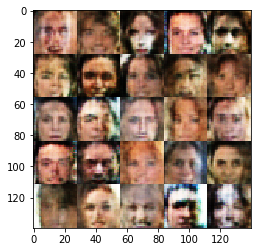

Epoch => 1/1  Discriminator Loss: 1.367 Generator Loss: 0.569
Epoch => 1/1  Discriminator Loss: 1.303 Generator Loss: 1.088
Epoch => 1/1  Discriminator Loss: 1.075 Generator Loss: 0.953
Epoch => 1/1  Discriminator Loss: 1.271 Generator Loss: 0.898
Epoch => 1/1  Discriminator Loss: 1.315 Generator Loss: 0.697

Plot Number > 14


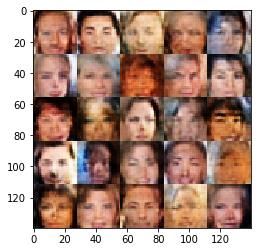

Epoch => 1/1  Discriminator Loss: 1.102 Generator Loss: 1.284
Epoch => 1/1  Discriminator Loss: 1.360 Generator Loss: 0.634
Epoch => 1/1  Discriminator Loss: 1.185 Generator Loss: 0.897
Epoch => 1/1  Discriminator Loss: 1.359 Generator Loss: 1.231
Epoch => 1/1  Discriminator Loss: 1.235 Generator Loss: 0.853

Plot Number > 15


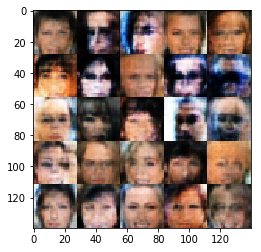

Epoch => 1/1  Discriminator Loss: 1.213 Generator Loss: 0.787
Epoch => 1/1  Discriminator Loss: 1.297 Generator Loss: 0.654
Epoch => 1/1  Discriminator Loss: 1.218 Generator Loss: 0.840
Epoch => 1/1  Discriminator Loss: 1.509 Generator Loss: 0.425
Epoch => 1/1  Discriminator Loss: 1.119 Generator Loss: 1.254

Plot Number > 16


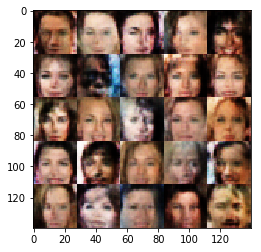

Epoch => 1/1  Discriminator Loss: 1.190 Generator Loss: 0.840
Epoch => 1/1  Discriminator Loss: 1.122 Generator Loss: 1.063
Epoch => 1/1  Discriminator Loss: 1.160 Generator Loss: 0.801
Epoch => 1/1  Discriminator Loss: 1.099 Generator Loss: 1.030
Epoch => 1/1  Discriminator Loss: 1.335 Generator Loss: 0.591

Plot Number > 17


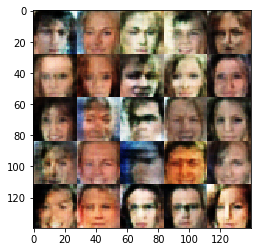

Epoch => 1/1  Discriminator Loss: 1.265 Generator Loss: 0.684
Epoch => 1/1  Discriminator Loss: 1.221 Generator Loss: 1.385
Epoch => 1/1  Discriminator Loss: 1.245 Generator Loss: 0.995
Epoch => 1/1  Discriminator Loss: 1.262 Generator Loss: 0.840
Epoch => 1/1  Discriminator Loss: 1.486 Generator Loss: 0.501

Plot Number > 18


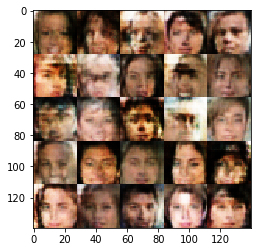

Epoch => 1/1  Discriminator Loss: 1.012 Generator Loss: 1.130
Epoch => 1/1  Discriminator Loss: 1.340 Generator Loss: 0.604
Epoch => 1/1  Discriminator Loss: 1.601 Generator Loss: 0.411
Epoch => 1/1  Discriminator Loss: 1.392 Generator Loss: 0.532
Epoch => 1/1  Discriminator Loss: 1.113 Generator Loss: 1.300

Plot Number > 19


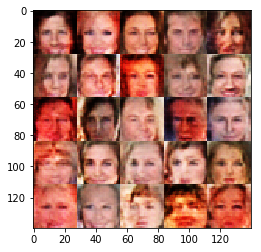

Epoch => 1/1  Discriminator Loss: 1.144 Generator Loss: 0.944
Epoch => 1/1  Discriminator Loss: 1.107 Generator Loss: 0.881
Epoch => 1/1  Discriminator Loss: 1.239 Generator Loss: 1.230
Epoch => 1/1  Discriminator Loss: 1.313 Generator Loss: 0.589
Epoch => 1/1  Discriminator Loss: 1.300 Generator Loss: 0.801

Plot Number > 20


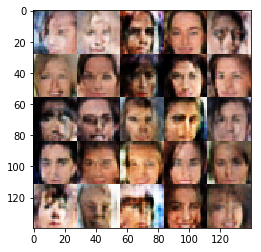

Epoch => 1/1  Discriminator Loss: 0.955 Generator Loss: 1.224
Epoch => 1/1  Discriminator Loss: 1.000 Generator Loss: 1.147
Epoch => 1/1  Discriminator Loss: 1.013 Generator Loss: 1.046
Epoch => 1/1  Discriminator Loss: 1.031 Generator Loss: 0.956
Epoch => 1/1  Discriminator Loss: 1.147 Generator Loss: 1.360

Plot Number > 21


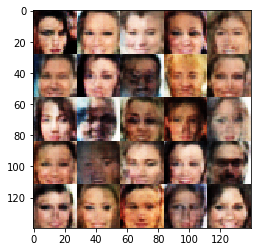

Epoch => 1/1  Discriminator Loss: 1.228 Generator Loss: 0.790
Epoch => 1/1  Discriminator Loss: 1.389 Generator Loss: 0.687
Epoch => 1/1  Discriminator Loss: 1.345 Generator Loss: 0.555
Epoch => 1/1  Discriminator Loss: 1.206 Generator Loss: 0.837
Epoch => 1/1  Discriminator Loss: 1.066 Generator Loss: 1.116

Plot Number > 22


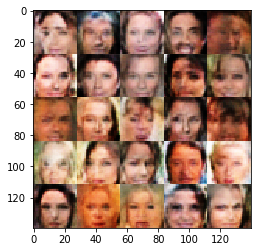

Epoch => 1/1  Discriminator Loss: 1.319 Generator Loss: 0.689
Epoch => 1/1  Discriminator Loss: 1.452 Generator Loss: 0.477
Epoch => 1/1  Discriminator Loss: 1.241 Generator Loss: 0.697
Epoch => 1/1  Discriminator Loss: 1.146 Generator Loss: 0.971
Epoch => 1/1  Discriminator Loss: 1.079 Generator Loss: 1.358

Plot Number > 23


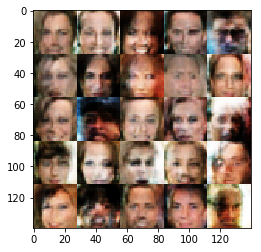

Epoch => 1/1  Discriminator Loss: 1.178 Generator Loss: 0.674
Epoch => 1/1  Discriminator Loss: 1.265 Generator Loss: 0.706
Epoch => 1/1  Discriminator Loss: 1.175 Generator Loss: 0.773
Epoch => 1/1  Discriminator Loss: 1.119 Generator Loss: 0.945
Epoch => 1/1  Discriminator Loss: 1.270 Generator Loss: 0.949

Plot Number > 24


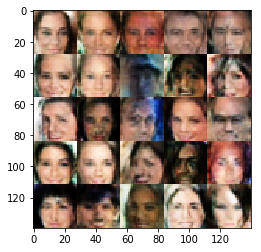

Epoch => 1/1  Discriminator Loss: 1.050 Generator Loss: 1.161
Epoch => 1/1  Discriminator Loss: 1.252 Generator Loss: 0.677
Epoch => 1/1  Discriminator Loss: 1.178 Generator Loss: 1.077
Epoch => 1/1  Discriminator Loss: 1.146 Generator Loss: 0.743
Epoch => 1/1  Discriminator Loss: 1.259 Generator Loss: 0.944

Plot Number > 25


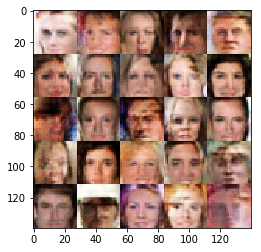

Epoch => 1/1  Discriminator Loss: 1.250 Generator Loss: 1.313
Epoch => 1/1  Discriminator Loss: 1.089 Generator Loss: 1.311
Epoch => 1/1  Discriminator Loss: 1.183 Generator Loss: 0.904
Epoch => 1/1  Discriminator Loss: 1.106 Generator Loss: 1.519
Epoch => 1/1  Discriminator Loss: 1.098 Generator Loss: 1.115

Plot Number > 26


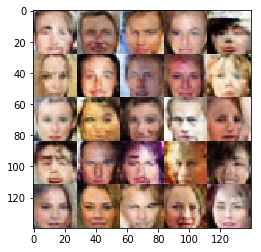

Epoch => 1/1  Discriminator Loss: 1.296 Generator Loss: 0.739
Epoch => 1/1  Discriminator Loss: 1.139 Generator Loss: 0.973
Epoch => 1/1  Discriminator Loss: 1.153 Generator Loss: 1.029
Epoch => 1/1  Discriminator Loss: 1.401 Generator Loss: 0.527
Epoch => 1/1  Discriminator Loss: 1.640 Generator Loss: 0.416

Plot Number > 27


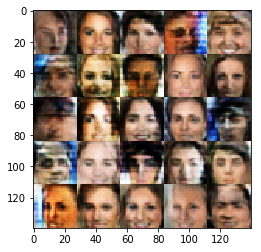

Epoch => 1/1  Discriminator Loss: 1.118 Generator Loss: 1.046
Epoch => 1/1  Discriminator Loss: 1.431 Generator Loss: 0.837
Epoch => 1/1  Discriminator Loss: 1.453 Generator Loss: 0.503
Epoch => 1/1  Discriminator Loss: 1.356 Generator Loss: 0.657
Epoch => 1/1  Discriminator Loss: 1.117 Generator Loss: 0.939

Plot Number > 28


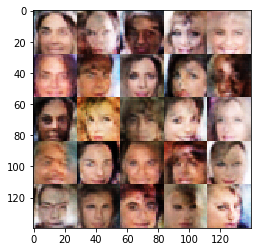

Epoch => 1/1  Discriminator Loss: 1.436 Generator Loss: 0.699
Epoch => 1/1  Discriminator Loss: 1.112 Generator Loss: 1.337
Epoch => 1/1  Discriminator Loss: 1.116 Generator Loss: 0.962
Epoch => 1/1  Discriminator Loss: 1.056 Generator Loss: 0.976
Epoch => 1/1  Discriminator Loss: 1.276 Generator Loss: 0.740

Plot Number > 29


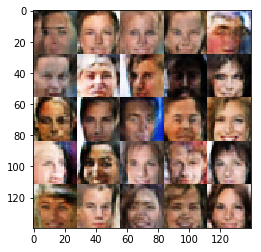

Epoch => 1/1  Discriminator Loss: 1.216 Generator Loss: 0.729
Epoch => 1/1  Discriminator Loss: 1.207 Generator Loss: 0.793
Epoch => 1/1  Discriminator Loss: 1.193 Generator Loss: 1.115
Epoch => 1/1  Discriminator Loss: 1.241 Generator Loss: 1.085
Epoch => 1/1  Discriminator Loss: 1.359 Generator Loss: 0.566

Plot Number > 30


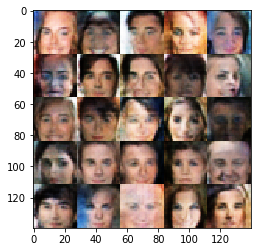

Epoch => 1/1  Discriminator Loss: 1.123 Generator Loss: 0.828
Epoch => 1/1  Discriminator Loss: 1.189 Generator Loss: 0.787
Epoch => 1/1  Discriminator Loss: 1.124 Generator Loss: 0.797
Epoch => 1/1  Discriminator Loss: 1.112 Generator Loss: 0.979
Epoch => 1/1  Discriminator Loss: 1.085 Generator Loss: 1.052

Plot Number > 31


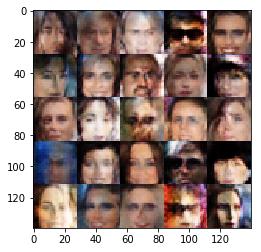

Epoch => 1/1  Discriminator Loss: 1.069 Generator Loss: 1.464
Epoch => 1/1  Discriminator Loss: 1.202 Generator Loss: 0.801
Epoch => 1/1  Discriminator Loss: 1.035 Generator Loss: 0.955


In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.0004
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.